# Trabalho Prático 2 - Boosting

**Nome: Eduardo Henrique Dias Melgaço** \
**Matrícula: 2017023501**

### Introdução
Este experimento tem a finalidade de colocar em prática os conceitos de Boosting através da implementação do algorimo. O método de Boosting consiste em criar um classificador forte à partir de outros classificadores fracos. Classificadores fortes demonstram maior confiança ao tentar predizer a classe de um dado, por exemplo: sendo P(x) a probabilidade de um dado pertencer à classe Y, o classificador retornaria valores próximo a 1 ou 0. Já um classificador fraco não possui tanta confiança e retorna valores próximos de 0.5 para a mesma tarefa. \
Para testar o algoritmo de Boosting, utilizamos o dataset Tic Tac Toe, onde para cada linha X e y são:
 - **X**: Uma lista com de tamanho 9, onde cada posição representa um quadrado no jogo da velha. Cada posição pode assumir os valores x, o e b (em branco);
 - **y**: Possui o valor 'positive' ou 'negative'. Quando y é positivo, significa que o jogador que utiliza a marca "x" venceu.  

### Bibliotecas utilizadas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold, cross_validate
from sklearn.base import BaseEstimator, ClassifierMixin
from tqdm.notebook import tqdm
import math


### Tratamento de dados
Nessa etapa substituímos os valores em texto, por valores inteiros, de forma a facilitar o processamento dos dados nas etapas à seguir. Por fim fazemos o split no dataset em dois conjuntos, o de teste e treinamento, no qual 25% dos dados serão utilizados para a validação.

In [2]:
df = pd.read_csv('tic-tac-toe.data', header=None, index_col=False)
df = df.replace({'positive': 1, 'negative': -1, 'x': 1, 'o': 2, 'b': 0})
y = df.iloc[:, -1]
X = df.iloc[:, 0:-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
print(y)
print(X)

0      1
1      1
2      1
3      1
4      1
      ..
953   -1
954   -1
955   -1
956   -1
957   -1
Name: 9, Length: 958, dtype: int64
     0  1  2  3  4  5  6  7  8
0    1  1  1  1  2  2  1  2  2
1    1  1  1  1  2  2  2  1  2
2    1  1  1  1  2  2  2  2  1
3    1  1  1  1  2  2  2  0  0
4    1  1  1  1  2  2  0  2  0
..  .. .. .. .. .. .. .. .. ..
953  2  1  1  1  2  2  2  1  1
954  2  1  2  1  1  2  1  2  1
955  2  1  2  1  2  1  1  2  1
956  2  1  2  2  1  1  1  2  1
957  2  2  1  1  1  2  2  1  1

[958 rows x 9 columns]


### Stumps

Um stump é equivalente à uma árvore de decisão com apenas um nó, isto é, o classificador avalia uma única característica do dado e retorna a predição com base nesse valor único. \
Olhando para as features do dataset, percebemos que X possui 9 posições que podem assumir 3 valores e que podem resultar em 2 classes. À partir desses valores, percebemos que existem $9\times3\times2 = 54$ combinações de stumps que podem ser testados, e incluindo os stumps All True e All False, obtemos o total de 56 combinações. \
A Classe stump abaixo recebe os seguintes atributos:
 - x_index: Indíce do valor em X;
 - x_index_value: Valor que X deve assumir em X[x_index]
 - y_pred: Valor que o stump prediz quando X[x_index] = x_index_value
 - type_stump: Caso for True ou False, o stump retorna apenas 1 ou -1 como predição

In [3]:
class Stump:
    def __init__(self, x_index, x_index_value, y_pred, type_stump=None):
        self.x_index = x_index 
        self.x_index_value = x_index_value
        self.y_pred = y_pred
        self.type_stump = type_stump
        
    def predict(self, x, type_stump=None):
        if(self.type_stump == True):
            return 1
        if(self.type_stump == False):
            return -1
            
        if(x[self.x_index] == self.x_index_value):
            return self.y_pred

        return -1 if self.y_pred == 1 else 1


Como mencionado anteriormente, existem 56 combinações de stump possíveis. A função abaixo cria estes 54 stumps à partir da variação dos valores de indíce do x, valor do x, e predição de y e acrescenta os dois stumps que predizem apenas verdadeiro ou falso.

In [4]:
def generate_stumps():
    stumps = []
    for x_idx in range(9):
        for mark_type in range(3):
            stumps.append(Stump(x_idx, mark_type, 1))
            stumps.append(Stump(x_idx, mark_type, -1))

    stumps.append(Stump(0, 1, 1, type_stump=True))
    stumps.append(Stump(0, 1, 1, type_stump=False))
    
    return stumps

### Construção do classificador utilizando Boosting

À seguir é possível visualizar a classe Boosting criada, que utiliza como entrada uma lista de stumps e o número de classificadores que serão utilizados. A classe pode ser explicada através de 2 fluxos principais, o de treinamento e o de teste:
 - **Treinamento**: O treinamento do modelo é feito a partir do método \fit\,que inicializa os pesos com o valor $\frac{1}{training\_size}$ e chama a função `find_best_stump` N vezes, onde N é o número de classificadores. Para encontrar o melhor stump a cada interação, o algoritmo executa a função `test_stumps` para cada stump inserido, guarda o resultado deles e depois seleciona o melhor (que possui o menor erro). Após a seleção do melhor stump do round atual, a função `adjust_weights` é chamada para que os pesos e os valores de alpha sejam ajustados conforme o seguinte critério:
 $$\alpha^t = \frac{1}{2}\times log(\frac{1 - \epsilon^t}{\epsilon^t})$$
 $$w^{t+1}_i = \frac{w^t_i}{z}\times e^{-\alpha^t\times h^t(X)\times y(X)}$$
 Onde z é um número arbitrário que garante que $\sum w^{t+1}_i = 1$ e $y\in \{-1, +1\}$. Ao utilizar o método acima para atualizar os pesos, garantimos que o próximo stump irá evitar errar os mesmos dados que o stump anterior, pois o peso associado à eles será maior na próxima iteração.
 - **Teste**: A fase de teste de performance do modelo é invocada à partir do método `score`, que itera sobre cada `X_test` e `y_test` testando se o resultado da função `predict` em `X_test[i]` é igual a `y_test[i]` para, por fim, retornar o seguinte valor:
 $$score = \frac{num\_acertos}{tamanho\_set}$$
 A função `predict` calcula a predição final com base na soma das predições dos n classificadores fracos multiplicados ao peso alpha calculado em cada round: 
 $$h^*(x) = h^1(x)\times \alpha^1 + h^2(x)\times \alpha^2 + h^3(x)\times \alpha^3 + ... + h^n(x)\times \alpha^n$$
 ----
 Uma decisão de implementação que impactou amplamente o resultado final foi permitir que houvesse repetição de stumps. Ao permitir que o algoritmo utilizasse o mesmo stump várias vezes, tiramos a limitação de classificadores do modelo. Também criamos a possibilidade do algoritmo conseguir capturar o mesmo aspecto, mas em cenários diferentes e com impactos diferentes no resultado final, pois para cada round a contribuição daquele stump será decida pelo valor de $\alpha$. Além disso, vale ressaltar que a classe pode ser utilizada para qualquer problema de classificação, isso se deve pelo fato dela receber a lista de stumps por parâmetro em seu construtor.

In [5]:
class Boosting(BaseEstimator, ClassifierMixin):
    def __init__(self, stumps=None, num_classifiers=5):
        self.weak_clfs = []
        self.alphas = []
        self.weighted_errors = []
        self.num_classifiers = num_classifiers
        self.stumps = stumps
        
    def find_best_stump(self):
        errors = []
        for idx, stump in enumerate(self.stumps):
            error, y_pred = self.test_stump(stump)
            errors.append([error, y_pred, stump])
        
        [best_error, best_y_pred, best_stump] = min(errors, key=lambda x: x[0])
        
        self.adjust_weights(best_y_pred, best_error)
        return best_stump
   
    def adjust_weights(self, y_pred, error):
        alpha = 1/2 * math.log((1 - error) / error)
        expression_1 = np.array(y_pred) * np.array(self.y_train) * -alpha
        e_powered = np.power(math.e, expression_1)
        weights = np.multiply(self.weights, e_powered)
        
        self.alphas.append(alpha)
        self.weighted_errors.append(error)
        self.weights = weights / np.sum(weights)
    
    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
        self.size = y.shape[0]
        self.weights = [1 / self.size] * self.size
        
        for idx in range(self.num_classifiers):
            self.weak_clfs.append(self.find_best_stump())
            
        return self
            
    def predict(self, x):
        sum_h = 0
        for idx, clf in enumerate(self.weak_clfs):
            sum_h += clf.predict(x) * self.alphas[idx]
            
        return np.sign(sum_h)
    
    def score(self, x, y):
        size = x.shape[0]
        correct_predictions = 0
        for idx in range(size):
            y_pred = self.predict(x[idx])
            if(y_pred == y[idx]):
                correct_predictions += 1
                
        return correct_predictions / size
        
    def test_stump(self, stump):
        error = 0
        y_pred = []
        for idx in range(self.size):
            prediction = stump.predict(self.X_train[idx])
            y_pred.append(prediction)
            if(prediction != self.y_train[idx]):
                error += self.weights[idx]
                
        return error, y_pred

### Treinamento

A metodologia de treinameto utilizada, conforme a especificação, é a de validação cruzada com 5 partições. Neste método de cross validation é utilizado a função `cross_validate` que cria 5 diferentes partições de teste e treinamento e retorna o resultado da performance dos 5 classificadores. À partir disso, ele pega o modelo com a melhor acurácia retorna a precisão em set de treinamento, de teste, e também o erro do último stump treinado pelo modelo.

In [10]:
def k_fold_train(X_train_total, y_train_total, stumps=None, num_classifiers=1):
    boost = Boosting( 
        num_classifiers=num_classifiers,
        stumps=stumps,
    )
    
    scores = cross_validate(boost, X_train_total, y_train_total, cv=5, return_estimator=True)
    
    best_clf = max(list(zip(scores['test_score'], scores['estimator'])), key=lambda x: x[0])
    training_score, best_boost = best_clf
    testing_score = best_boost.score(X_test.values, y_test.values)
    
    return training_score, testing_score, best_boost.weighted_errors[-1]

### Avaliação do modelo

Por fim, na função abaixo executamos um experimento que captura os erros de teste e treinamento no classificador e o erro ponderado do último stump. Esse experimento cria 200 classificadores que utilizam de 1 à 200 stumps cada. À partir disso, fica evidente a relação entre o número de stumps no Boosting e a performance final.

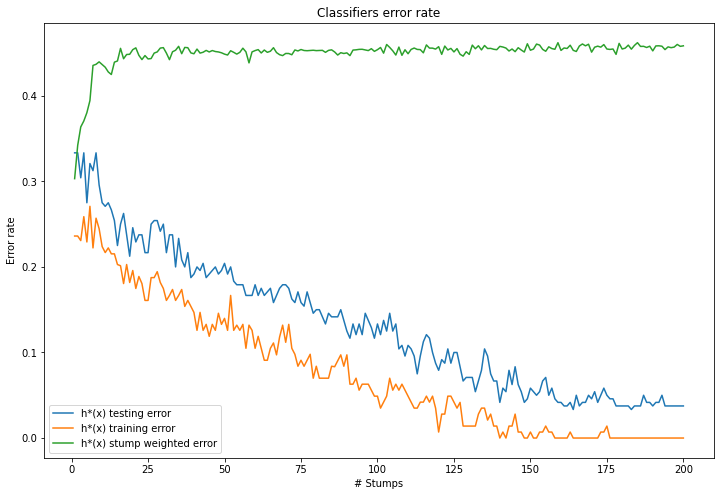

In [12]:
def evaluate_boosting():
    stumps = generate_stumps()
    
    testing_errors = []
    training_errors = []
    weighted_errors = []
    num_clf_range = range(1, 201)
    for num_clf in tqdm(num_clf_range):
        training_score, testing_score, weighted_error = k_fold_train(X_train.values, y_train.values, \
                         num_classifiers=num_clf, stumps=stumps)
        testing_errors.append(1 - testing_score)
        training_errors.append(1 - training_score)
        weighted_errors.append(weighted_error)
        
    fig, ax = plt.subplots(figsize=(12,8))
    ax.plot(num_clf_range, testing_errors, label='h*(x) testing error')
    ax.plot(num_clf_range, training_errors, label='h*(x) training error')
    ax.plot(num_clf_range, weighted_errors, label='h*(x) stump weighted error')
    ax.set_xlabel('# Stumps')
    ax.set_ylabel('Error rate')
    ax.set_title('Classifiers error rate')
    ax.legend()
        
evaluate_boosting()     

À partir da análise do gráfico acima, podemos perceber que à medida que adicionamos mais stumps ao classificador o erro do stump referente àquele round aumenta, enquanto o erro de treinamento e teste do classificador diminui de forma significativa. Quando o experimento chega no final, a precisão em conjunto de treinamento chega a ser 100% e em conjunto de teste ela é 99%, o que demonstra o quão poderosa, apesar de simples, a técnica de Boosting é.

### Referências
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html \
http://scikit-learn.org/stable/developers/develop.html \
https://homepages.dcc.ufmg.br/~adrianov/ml/ 